In [106]:
from music21 import converter, instrument, note, chord, stream, midi
from google.colab import files
import glob
import os
import gzip
import tarfile    
from torchvision import datasets                  
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

assert torch.cuda.is_available()

In [3]:
# Import Drive for easier saving
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def download_data(filepath):
    if not os.path.exists(os.path.join(filepath, 'mozart_sonatas.tar.gz')):
      datasets.utils.download_url('https://github.com/Foundations-of-Applied-Mathematics/Data/raw/master/RNN/mozart_sonatas.tar.gz', filepath, 'mozart_sonatas.tar.gz', None)

    print('Extracting {}'.format('mozart_sonatas.tar.gz'))
    gzip_path = os.path.join(filepath, 'mozart_sonatas.tar.gz')
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())

    print('Untarring {}'.format('mozart_sonatas.tar'))
    tar_path = os.path.join(filepath,'mozart_sonatas.tar')
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))



**Problem 1**:

Download the data.
Write a function that accepts the path to the .mid files, parses the files, and returns a list of the $119348$ pitches as strings. 
For the Chords, join the pitches of the notes in the chords with a . as in D3.D2.

Print the length of your list and the number of unique pitches.


In [5]:
download_data('drive/MyDrive/Colab')

Extracting mozart_sonatas.tar.gz
Untarring mozart_sonatas.tar


In [6]:
def parse(path="drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas"):
    res = []
    for filename in os.listdir(path):
        # parse the file
        f = os.path.join(path, filename)
        midi = converter.parse(f)
        notes_to_parse = instrument.partitionByInstrument(midi).parts[0].recurse()

        # Append the notes to the list
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                res.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes = ".".join([str(pitch) for pitch in element.pitches])
                res.append(notes)
    return res
all_notes = parse()

In [7]:
print(len(all_notes))
print(len(set(all_notes)))

119348
741


**Problem 2.** 

Using the list returned in Problem 1, create the training and testing DataLoaders.
Make sure to do all of the following steps:


1) Convert the pitches to integers.
2) Split the data into Long tensors of length 100.
3) Create the labels.
4) Randomly split the data into training and test sets using an 80/20 split.
5) Create the DataLoaders for both sets of data, using batch_size=128 for the training data and batch_size=1 for the test data.
 

Print the length of each DataLoader.


In [8]:
from sklearn.model_selection import train_test_split

notes_num_dict = {n: i for i, n in enumerate(set(all_notes))}
num_notes_dict = {notes_num_dict[key]:key for key in notes_num_dict.keys()}
seq_length = 100

sequences = [[notes_num_dict[letter] for letter in all_notes[i:(i + seq_length)]]
             for i in range(len(all_notes) - seq_length)]
labels = [s[0] for s in sequences[1:]]
sequences = np.array(sequences[:-1])

X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
X_train = [[torch.tensor(x).long(), torch.tensor(y).long()] for x, y in zip(X_train, y_train)]
X_test = [[torch.tensor(x).long(), torch.tensor(y).long()] for x, y in zip(X_test, y_test)]

In [9]:
print(len(sequences))
print(len(labels))

119247
119247


In [19]:
train_batch_size = 128
test_batch_size = 1
train_loader = DataLoader(X_train, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(X_test, batch_size=test_batch_size, shuffle=True)

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.size())
print(labels.size())
print(len(train_loader))
print(len(test_loader))

torch.Size([128, 100])
torch.Size([128])
745
23850


**Problem 3**

Create the network class.
Include at least $3$ LSTM layers, each followed by Dropout layers with probability $.3.$
Also have at least $2$ Linear layers.
The last LSTM layer and each of the Linear layers should be followed by a BatchNorm1d layer, for at least $3$ total batchnorm layers.
The final layer should be a Softmax activation.

Initialize the model, loss as CrossEntropyLoss, and optimizer as RMSprop.

Train the model until the accuracy is above 95\%. This can take?



After taking a backwards step during training, scale the gradients using 
nn.utils.clip_grad_norm_(model.parameters(), 5)
This will ensure that the gradients are reasonably sized so that the model can learn.

At the end of each epoch, calculate the accuracy and mean loss on the test data.
Remember to change the model to eval() mode when running the test data and train() when running on the training data.

After the accuracy is above 95\%, plot the training and test losses versus epochs on the same plot.
Plot the accuracy versus epochs.


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Network(nn.Module):
    '''
    Recurrent Neural Network Class
    '''
    def __init__(self, n_notes=741, embedding_dim=32):
        super(Network, self).__init__()
        # initialize layers
        self.hidden_size = 512
        self.num_layers = 3
        self.dropout = 0.3
        self.n_notes = n_notes
        self.embedding = nn.Embedding(n_notes,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_size, self.num_layers, batch_first=True, dropout=.3)
        self.batch0 = nn.BatchNorm1d(self.hidden_size)
        self.batch1 = nn.BatchNorm1d(10)
        self.batch2 = nn.BatchNorm1d(n_notes)
        self.dropout = nn.Dropout(.3)
        self.linear1 = nn.Linear(self.hidden_size, 10)
        self.linear2 = nn.Linear(10, self.n_notes)

        self.softmax = nn.LogSoftmax(dim=1)
 
    def forward(self, x, hidden):
        # forward pass
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        out = self.dropout(self.batch0(lstm_out[:,-1])) #output from final step is ←- passed forward
        out = self.batch1(self.linear1(out))
        out = self.batch2(self.linear2(out))
        return self.softmax(out), hidden

    def initHidden(self,batch_size):
        # initialize the hidden layers
        weight = next(self.parameters()).data
        h0 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        h1 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        return (h0, h1)


# Initialize the model
model = Network().cuda()
optimizer = torch.optim.RMSprop(model.parameters(),lr=.001)
objective = nn.CrossEntropyLoss()
filepath = '/content/drive/MyDrive/Colab/parameters.pt'
accuracies = []
training_losses = []

for epoch in range(3):
    model.train()
    loop = tqdm(total = len(train_loader), position=0, leave=False)
    for i, data in enumerate(train_loader, 0):
        # initialize the hidden states
        (h0, h1) = model.initHidden(128)
        h0 = h0.cuda()
        h1 = h1.cuda()
        # pass data through the model

        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad() # Zero out the the gradients
        outputs = model(inputs, (h0, h1)) # Run the model
        loss = objective(outputs[0], labels) # Calculate loss
        loss.backward() # Compute gradients
        optimizer.step() # Optimize and update the weights


        outputs, (h0, h1) = model(inputs, (h0,h1))
        h0 = h0.detach()
        h1 = h1.detach()
        accuracy = (outputs.argmax(1) == labels).float().mean()
        loop.set_description('epoch:{} loss:{:.4f} accuracy:{:.3f}'.format(epoch, loss.item(), accuracy))
        loop.update(1)
        training_losses.append(loss.item())
        accuracies.append(accuracy)
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,}, filepath)
    model.eval()

epoch:2 loss:0.5504 accuracy:0.930: 100%|██████████| 745/745 [05:04<00:00,  2.45it/s]

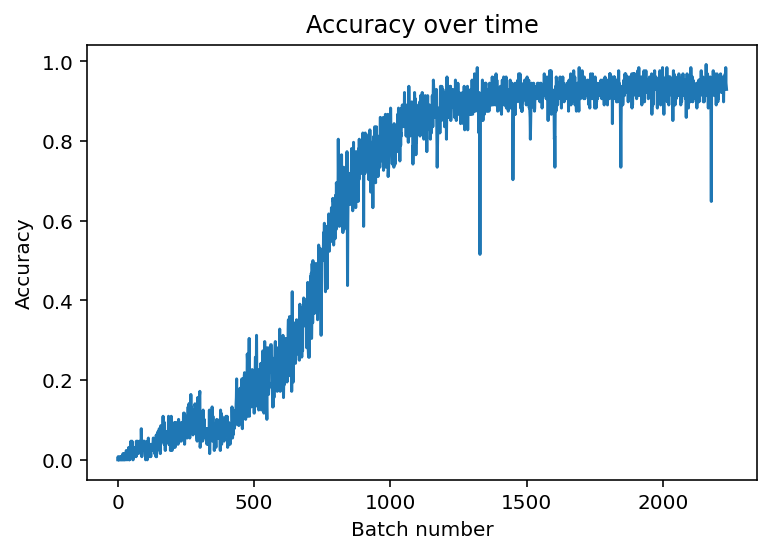

In [44]:
plt.plot(range(len(accuracies)), [a.item() for a in accuracies])
plt.title("Accuracy over time")
plt.xlabel("Batch number")
plt.ylabel("Accuracy")
plt.show()

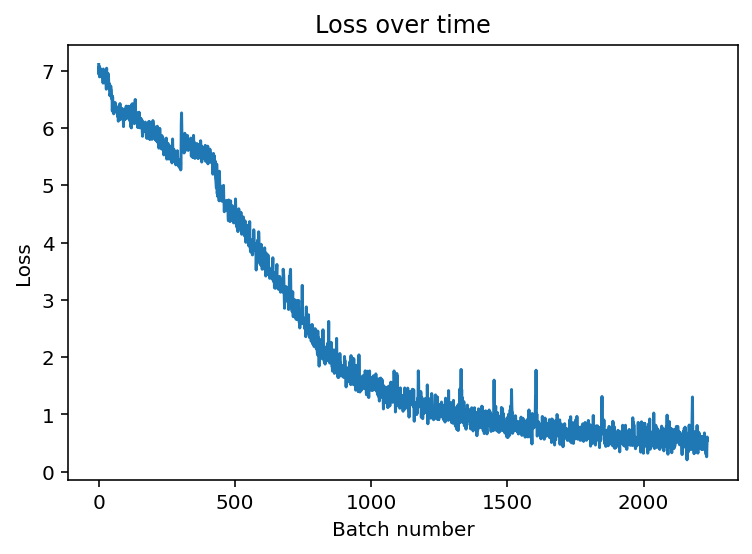

In [45]:
plt.plot(range(len(training_losses)), [a for a in training_losses])
plt.title("Loss over time")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.show()

**Problem 4.** 
Write a function that randomly chooses a sequence in the test data and predicts
the next 500 elements. 
Return a list of the 600 pitches in the sequence.

In [33]:
def load_model(filename):
    """ Load a saved model to continue training or evaluate """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = Network()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(),lr=.001)

    checkpoint = torch.load(filename,map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    model.eval() # For evaluation only
  
    return model, criterion, optimizer

In [102]:
def predict(X_test, model):
    random_select = np.random.randint(0, len(test_loader) - 1)
    seq, label = X_test[random_select] # should be test set, not test loader
    seq = seq.cuda()
    (h0, h1) = model.initHidden(1)
    for _ in range(500):
        #print([s.item() for s in seq])
        #print()
        input = torch.tensor([s.item() for s in seq][-100:]).unsqueeze(0).cuda().long()
        #print(input.shape)
        prediction, (h0, h1) = model(input, (h0, h1))
        #print(prediction.argmax(1))
        torch.cat((seq, prediction.argmax(1)))
        #print(seq)
        #print()
    return [num_notes_dict[s.item()] for s in seq]

**Problem 5.** 
Convert the sequence from Problem 4 into note and chord objects and save it to
'mozart.mid'.

In [103]:
seq = predict(X_test, model)
print(seq)

['C#4', 'C#6', 'E5', 'F#5', 'D4', 'A5', 'D5', 'C#5', 'E4', 'E5', 'A4', 'B4', 'E3', 'D5', 'G#4', 'A4', 'A3', 'C#6', 'E5.A4', 'B5', 'F5.G#4', 'A5', 'F#5.F#4', 'G#5', 'C#5.E4', 'F#5', 'D5.D4', 'E5', 'A4.C#4', 'E5', 'G#4.B3', 'D5', 'C#5', 'A4.A3', 'E5', 'E4.C#4', 'A4.F#4', 'D5', 'E4.G#4', 'C#5', 'F#4.D4', 'B4', 'E-4.F#4', 'A4', 'C#5', 'A4', 'E4', 'B4', 'G#4', 'C#6', 'A4', 'E5', 'D6', 'C#6', 'B5', 'G#4', 'E-6', 'E6', 'A5', 'F#4', 'C#5', 'B5', 'A5', 'G#5', 'E4', 'C6', 'C#6', 'F#5', 'D4', 'A4', 'G5', 'F#5', 'E5', 'C#4', 'G#5', 'A5', 'E5', 'G#4.B3', 'D5', 'C#5', 'A4.A3', 'E5', 'C#3', 'A3', 'D3', 'F#5', 'D5', 'D4', 'B4', 'A4', 'E3', 'C#4', 'C#5', 'G#3', 'B4', 'A4', 'A2', 'C#3', 'E3', 'A3']


In [110]:
chords = []

offset = .5

for item in seq:
    # Create note objects for each pitch in the chord
    notes = []
    for pitch in item.split('.'):
        new_note = note.Note(pitch)
        new_note.storedInstrument = instrument.Piano()
        notes.append(new_note)

    # Create a Chord object
    new_chord = chord.Chord(notes)
    new_chord.offset = offset
    offset += .5
    chords.append(new_chord)

midi_stream = stream.Stream(chords)
midi_stream.write('midi', fp="/content/final_result.midi")

'/content/final_result.midi'

In [81]:
l = [1, 2, 3, 4, 5]
print(l[-3:])

[3, 4, 5]
